<a href="https://colab.research.google.com/github/DihedralG/HIA-Geodetic-Codex/blob/main/v2_v3_polyhedral_mesh_overlay.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# --- Cell 1: setup ---
!pip -q install cartopy

import os, urllib.request, importlib.util, zipfile, io
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

plt.rcParams['figure.dpi'] = 150
OUTDIR = "/content/out"; os.makedirs(OUTDIR, exist_ok=True)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 59.3 MB/s eta 0:00:00


In [2]:
# --- Cell 2: fetch V3 mesh helper ---
RAW_URL = "https://raw.githubusercontent.com/DihedralG/HIA-Geodetic-Codex/main/scripts/v3/polyhedral_mesh.py"
DST = "/content/polyhedral_mesh.py"
urllib.request.urlretrieve(RAW_URL, DST)
print("Downloaded:", os.path.abspath(DST))

spec = importlib.util.spec_from_file_location("polyhedral_mesh", DST)
pm = importlib.util.module_from_spec(spec)
spec.loader.exec_module(pm)

Downloaded: /content/polyhedral_mesh.py


In [4]:
# --- Cell 3 (revised): robust V3 geodesic mesh builder (no off-by-one) ---
import numpy as np

R_EARTH_KM = 6371.0088

def _icosahedron_unit():
    phi = (1.0 + 5.0**0.5) / 2.0
    V = np.array([
        (-1,  phi, 0), ( 1,  phi, 0), (-1, -phi, 0), ( 1, -phi, 0),
        ( 0, -1,  phi), ( 0,  1,  phi), ( 0, -1, -phi), ( 0,  1, -phi),
        ( phi, 0, -1), ( phi, 0,  1), (-phi, 0, -1), (-phi, 0,  1)
    ], dtype=float)
    V /= np.linalg.norm(V, axis=1, keepdims=True)
    F = np.array([
        (0,11,5),(0,5,1),(0,1,7),(0,7,10),(0,10,11),
        (1,5,9),(5,11,4),(11,10,2),(10,7,6),(7,1,8),
        (3,9,4),(3,4,2),(3,2,6),(3,6,8),(3,8,9),
        (4,9,5),(2,4,11),(6,2,10),(8,6,7),(9,8,1)
    ], dtype=int)
    return V, F

def _subdivide_face_points(a, b, c, f):
    """Return all vertex positions and small triangles for one face (local indices)."""
    # Barycentric grid on the spherical triangle
    grid = []
    for i in range(f+1):
        row = []
        for j in range(f - i + 1):
            u = f - i - j
            v = j
            w = i
            p = (u*a + v*b + w*c) / float(f)
            p = p / np.linalg.norm(p)
            row.append(p)
        grid.append(row)

    pts = []
    tris = []
    def add(p):
        pts.append(p); return len(pts)-1

    for i in range(f):
        for j in range(f - i):
            # upper-left small tri
            v00 = add(grid[i][j])
            v01 = add(grid[i][j+1])
            v10 = add(grid[i+1][j])
            tris.append((v00, v01, v10))
            # lower-right small tri (exists except on the right edge)
            if j < f - i - 1:
                v11 = add(grid[i+1][j+1])
                v01b = add(grid[i][j+1])
                v10b = add(grid[i+1][j])
                tris.append((v01b, v11, v10b))
    return np.asarray(pts), np.asarray(tris, dtype=int)

def geodesic_icosahedron_safe(f=6, eps=1e-12):
    """Return (V, E, F) for a frequency-f icosahedral geodesic sphere."""
    V0, F0 = _icosahedron_unit()

    # global unique vertices via hash on rounded coords
    key = lambda p: tuple(np.round(p, 12))
    index = {}
    V = []
    F = []

    for (i, j, k) in F0:
        a, b, c = V0[i], V0[j], V0[k]
        pts, tris = _subdivide_face_points(a, b, c, f)

        # map local -> global
        base = []
        for p in pts:
            kp = key(p)
            if kp not in index:
                index[kp] = len(V)
                V.append(p)
            base.append(index[kp])

        for (a1, b1, c1) in tris:
            F.append((base[a1], base[b1], base[c1]))

    V = np.asarray(V)
    F = np.asarray(F, dtype=int)

    # edges from faces
    e_set = set()
    for (a, b, c) in F:
        for u, v in ((a, b), (b, c), (c, a)):
            if u > v: u, v = v, u
            e_set.add((u, v))
    E = np.asarray(sorted(e_set), dtype=int)

    return V, E, F

# Build the mesh (f=6 by default)
V, E, F = geodesic_icosahedron_safe(f=6)
print(f"V3 mesh → nodes={len(V)}  edges={len(E)}  faces={len(F)}")
# For a canonical icosahedral geodesic sphere you should see:
# faces = 20*f^2 = 720
# edges  = 30*f^2 = 1080
# nodes  ≈ 10*f^2 + 2 = 362

V3 mesh → nodes=362  edges=1080  faces=720


In [5]:
# --- Cell 4: helpers (geodesic arcs + drawing) ---
R_EARTH_KM = 6371.0088

def sph2cart(lon_deg, lat_deg):
    lon, lat = np.radians(lon_deg), np.radians(lat_deg)
    x = np.cos(lat)*np.cos(lon)
    y = np.cos(lat)*np.sin(lon)
    z = np.sin(lat)
    return np.array([x, y, z])

def cart2sph(x, y, z):
    lon = np.degrees(np.arctan2(y, x))
    hyp = np.sqrt(x*x + y*y)
    lat = np.degrees(np.arctan2(z, hyp))
    return lon, lat

def gc_arc(lon1, lat1, lon2, lat2, n=128):
    """Interpolate points along the great circle from A to B (spherical linear interpolation)."""
    A = sph2cart(lon1, lat1); B = sph2cart(lon2, lat2)
    A = A/np.linalg.norm(A); B = B/np.linalg.norm(B)
    omega = np.arccos(np.clip(np.dot(A, B), -1, 1))
    if np.isclose(omega, 0):
        return np.array([lon1, lon2]), np.array([lat1, lat2])

    t = np.linspace(0, 1, n)
    sin_omega = np.sin(omega)
    pts = (np.sin((1-t)*omega)/sin_omega)[:,None]*A + (np.sin(t*omega)/sin_omega)[:,None]*B
    pts = pts/np.linalg.norm(pts, axis=1, keepdims=True)
    lons, lats = cart2sph(pts[:,0], pts[:,1], pts[:,2])
    return lons, lats

def draw_corridor_lon(ax, lon_deg, *, color="tab:blue", lw=2, ls="--", label=None):
    ax.plot([lon_deg, lon_deg], [-90, 90], transform=ccrs.Geodetic(),
            color=color, lw=lw, ls=ls, label=label)

def draw_parallel(ax, lat_deg, *, color="orange", lw=1.5, ls="--", label=None):
    ax.plot([-180, 180], [lat_deg, lat_deg], transform=ccrs.Geodetic(),
            color=color, lw=lw, ls=ls, label=label)

def draw_gc(ax, lon1, lat1, lon2, lat2, *, n=256, color="crimson", lw=2.0, alpha=1.0, label=None):
    lons, lats = gc_arc(lon1, lat1, lon2, lat2, n=n)
    ax.plot(lons, lats, transform=ccrs.Geodetic(), color=color, lw=lw, alpha=alpha, label=label)

def draw_mesh_edges(ax, V, E, *, color="steelblue", alpha=0.35, lw=0.6):
    for (i, j) in E:
        lon1, lat1 = cart2sph(*V[i]); lon2, lat2 = cart2sph(*V[j])
        draw_gc(ax, lon1, lat1, lon2, lat2, n=64, color=color, lw=lw, alpha=alpha)

def draw_mesh_nodes(ax, V, *, s=4, color="steelblue"):
    lons, lats = cart2sph(V[:,0], V[:,1], V[:,2])
    ax.scatter(lons, lats, s=s, color=color, transform=ccrs.PlateCarree(), alpha=.8, zorder=3)

In [6]:
# --- Cell 5: V2 anchors + corridors ---

# Key anchors you’ve used repeatedly (feel free to edit):
NODES = {
    # northern / “up”
    "MHO (VerdeMont, USA)": (-72.66, 44.5),
    "Ciudad Perdida (CPO, Colombia)": (-73.5, 11.2),
    "Giza Plateau (GZP, Egypt)": (31.1342, 29.9792),

    # southern / “down”
    "Adams Calendar (ACO, South Africa)": (30.0, -25.0),

    # extras often shown in your figs (toggle visibility later)
    "Sayacmarca (SO, Peru)": (-72.5, -13.2),
    "Monte Verde II (MVO layer)": (-73.2, -41.5),
}

# Trihedral “3-up / 1-down” sets (pick which to use — these default to a clean quartet):
UP_LABELS   = ["MHO (VerdeMont, USA)", "Ciudad Perdida (CPO, Colombia)", "Giza Plateau (GZP, Egypt)"]
DOWN_LABEL  = "Adams Calendar (ACO, South Africa)"

# Corridor meridians you use a lot:
CORRIDOR_LONS = [
    (-72.66, "72.66°W Corridor"),
     (31.0, "31°E Corridor"),
    (107.0, "107°E Corridor"),
   (-168.0, "168°W Corridor"),
]

TROPICS = [+23.4367, -23.4367]  # Cancer, Capricorn

/usr/local/lib/python3.11/dist-packages/cartopy/io/__init__.py:242: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.11/dist-packages/cartopy/io/__init__.py:242: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_ocean.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.11/dist-packages/cartopy/io/__init__.py:242: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


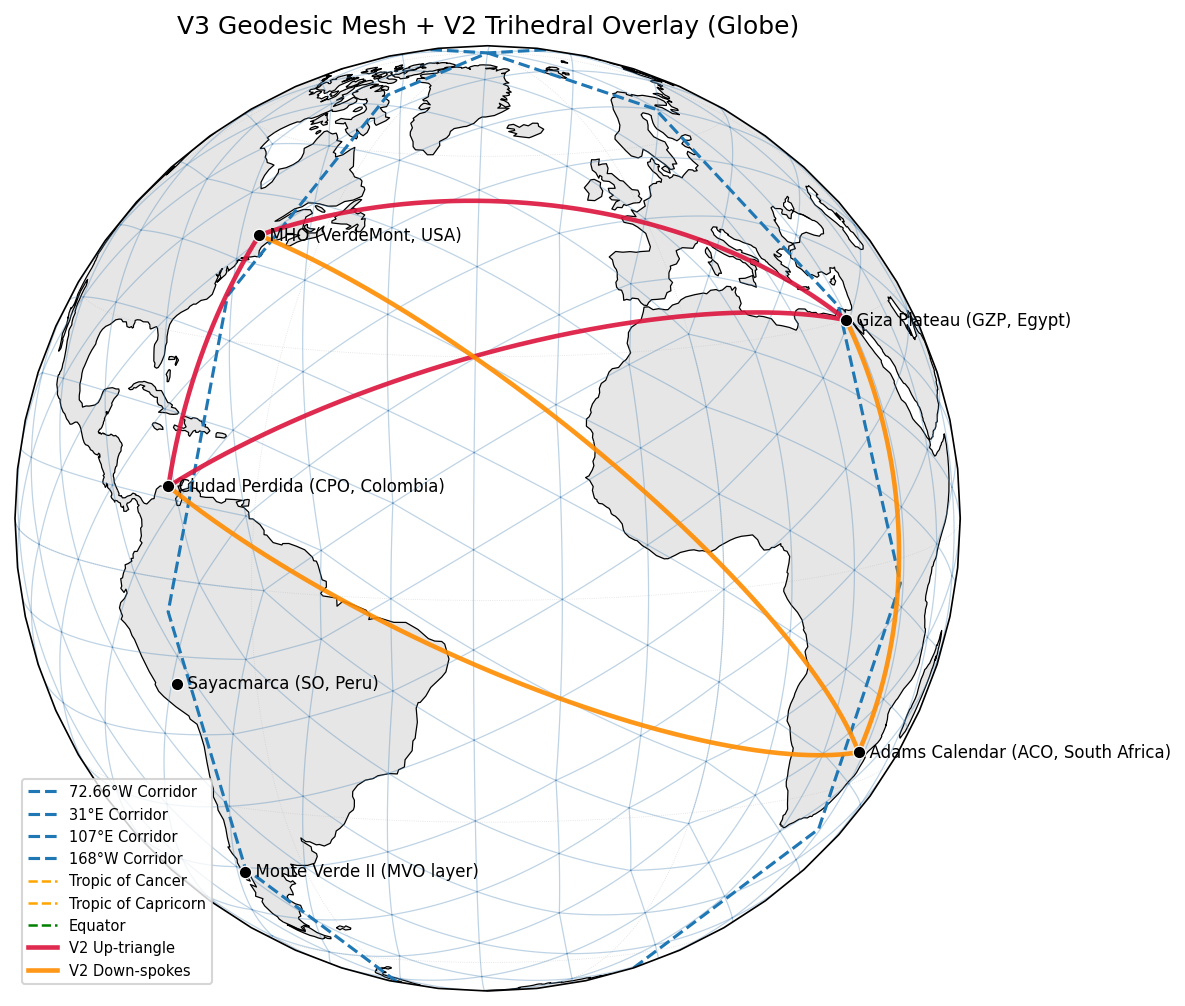

In [7]:
# --- Cell 6: globe view (orthographic) ---
center_lon, center_lat = -30, 10  # adjust to taste

fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection=ccrs.Orthographic(central_longitude=center_lon, central_latitude=center_lat))
ax.add_feature(cfeature.LAND, facecolor="#E6E6E6", zorder=0)
ax.add_feature(cfeature.OCEAN, facecolor="white", zorder=0)
ax.add_feature(cfeature.COASTLINE, linewidth=0.6, zorder=1)
ax.gridlines(draw_labels=False, linewidth=0.4, linestyle=':', alpha=0.4)

# V3 overlay
draw_mesh_edges(ax, V, E, color="steelblue", alpha=0.35, lw=0.6)

# V2 corridors
for lon, name in CORRIDOR_LONS:
    draw_corridor_lon(ax, lon, color="tab:blue", lw=1.5, ls="--", label=name)

# Tropics + Equator
for lat in TROPICS:
    draw_parallel(ax, lat, color="orange", lw=1.2, ls="--", label=("Tropic of Cancer" if lat>0 else "Tropic of Capricorn"))
draw_parallel(ax, 0.0, color="green", lw=1.2, ls="--", label="Equator")

# V2 trihedral edges: connect each UP to each other (triangle) + each UP to DOWN
up_pts = [NODES[k] for k in UP_LABELS]
down_pt = NODES[DOWN_LABEL]

# “Up” triangle
for i in range(3):
    a = up_pts[i]
    b = up_pts[(i+1)%3]
    draw_gc(ax, a[0], a[1], b[0], b[1], n=256, color="crimson", lw=2.2, alpha=0.9, label=None if i else "V2 Up-triangle")

# spokes to “down”
for i, a in enumerate(up_pts):
    draw_gc(ax, a[0], a[1], down_pt[0], down_pt[1], n=256, color="darkorange", lw=2.2, alpha=0.9, label=None if i else "V2 Down-spokes")

# Anchor markers
for label, (lon, lat) in NODES.items():
    ax.scatter(lon, lat, s=36, color="black", edgecolors="white", linewidths=0.6,
               transform=ccrs.PlateCarree(), zorder=3)
    ax.text(lon, lat, "  " + label, transform=ccrs.PlateCarree(),
            fontsize=8, va="center", ha="left", zorder=4)

plt.title("V3 Geodesic Mesh + V2 Trihedral Overlay (Globe)")
plt.legend(loc="lower left", fontsize=7)
plt.tight_layout()
plt.savefig(f"{OUTDIR}/v3_v2_globe.png", dpi=200)
plt.show()

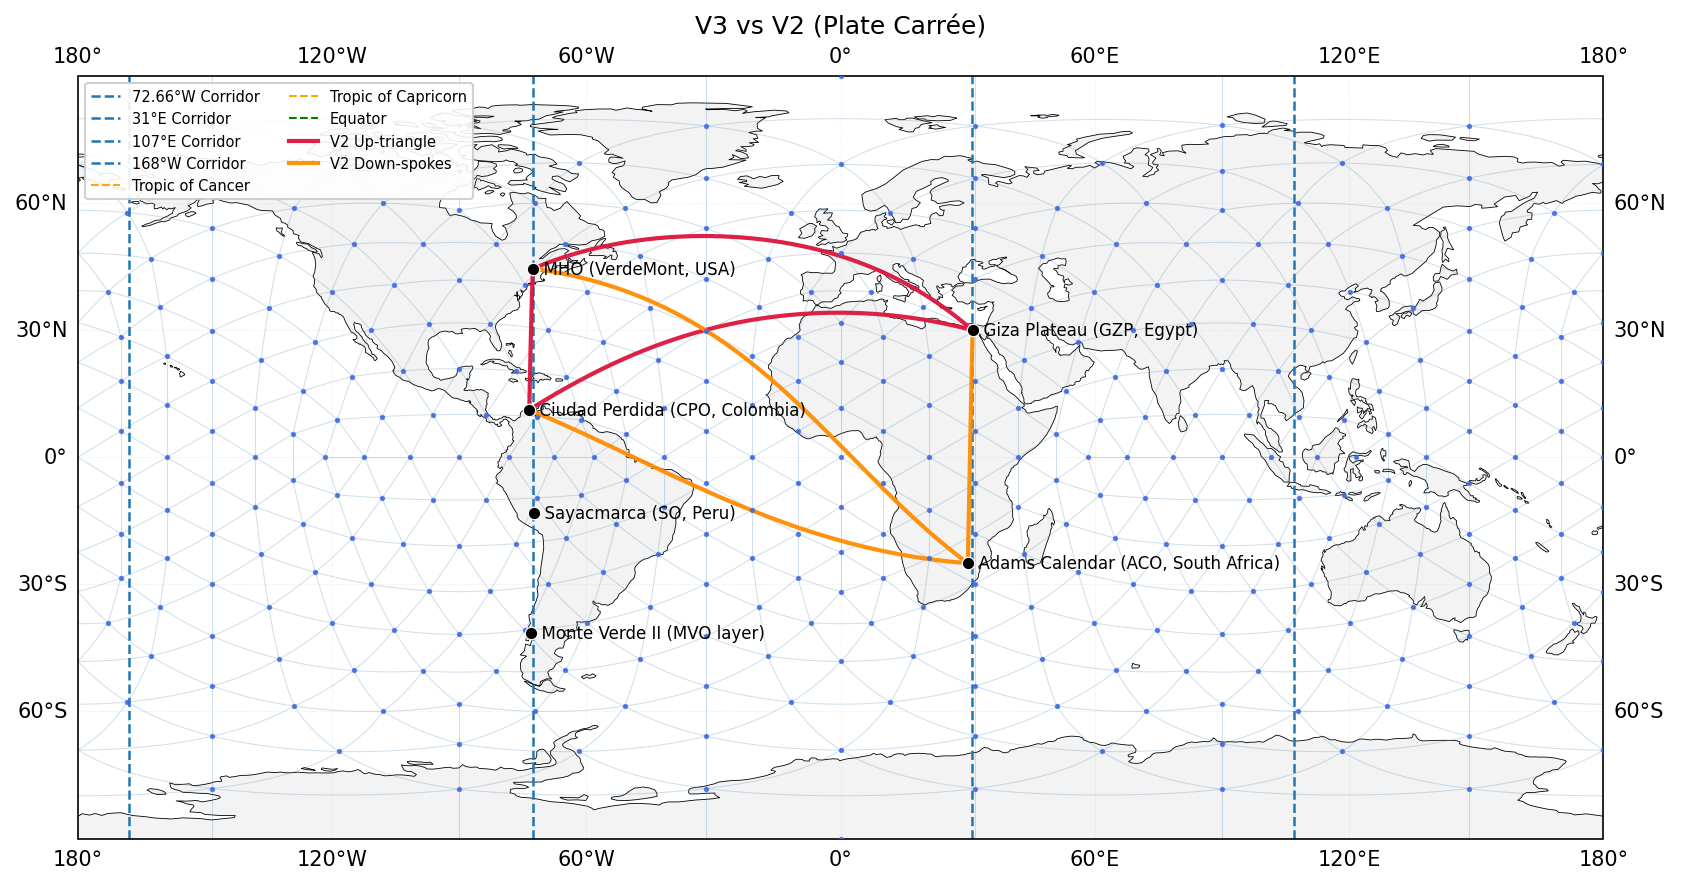

In [8]:
# --- Cell 7: plate carrée (global audit view) ---
fig = plt.figure(figsize=(12,6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.add_feature(cfeature.LAND, facecolor="#F3F3F3", zorder=0)
ax.add_feature(cfeature.OCEAN, facecolor="white", zorder=0)
ax.add_feature(cfeature.COASTLINE, linewidth=0.4, zorder=1)
ax.gridlines(draw_labels=True, linewidth=0.3, linestyle=':', alpha=0.4)

# Mesh (edges only for clarity)
draw_mesh_edges(ax, V, E, color="steelblue", alpha=0.25, lw=0.5)
draw_mesh_nodes(ax, V, s=2.5, color="royalblue")

# V2 corridors
for lon, name in CORRIDOR_LONS:
    draw_corridor_lon(ax, lon, color="tab:blue", lw=1.2, ls="--", label=name)

# Tropics + Equator
for lat in TROPICS:
    draw_parallel(ax, lat, color="orange", lw=1.0, ls="--", label=("Tropic of Cancer" if lat>0 else "Tropic of Capricorn"))
draw_parallel(ax, 0.0, color="green", lw=1.0, ls="--", label="Equator")

# V2 edges
up_pts = [NODES[k] for k in UP_LABELS]
down_pt = NODES[DOWN_LABEL]
for i in range(3):
    a = up_pts[i]; b = up_pts[(i+1)%3]
    draw_gc(ax, a[0], a[1], b[0], b[1], n=512, color="crimson", lw=2.0, alpha=0.95, label=None if i else "V2 Up-triangle")
for i, a in enumerate(up_pts):
    draw_gc(ax, a[0], a[1], down_pt[0], down_pt[1], n=512, color="darkorange", lw=2.0, alpha=0.95, label=None if i else "V2 Down-spokes")

# Anchors
for label, (lon, lat) in NODES.items():
    ax.scatter(lon, lat, s=36, color="black", edgecolors="white", linewidths=0.6,
               transform=ccrs.PlateCarree(), zorder=3)
    ax.text(lon, lat, "  " + label, transform=ccrs.PlateCarree(), fontsize=8, va="center", ha="left", zorder=4)

plt.title("V3 vs V2 (Plate Carrée)")
plt.legend(loc="upper left", fontsize=7, ncol=2, framealpha=0.9)
plt.tight_layout()
plt.savefig(f"{OUTDIR}/v3_v2_platecarree.png", dpi=200)
plt.show()

In [9]:
# --- Cell 8: optional distance audit for V2 edges ---
def gc_distance_km(a, b):
    # great-circle distance (haversine)
    lon1, lat1 = np.radians(a); lon2, lat2 = np.radians(b)
    dlon = lon2 - lon1; dlat = lat2 - lat1
    h = np.sin(dlat/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2)**2
    return 2*R_EARTH_KM*np.arcsin(np.sqrt(h))

ups = [NODES[k] for k in UP_LABELS]
down = NODES[DOWN_LABEL]

print("— V2 Edge Lengths (km / miles) —")
for i in range(3):
    a, b = ups[i], ups[(i+1)%3]
    dkm = gc_distance_km((a[0],a[1]), (b[0],b[1]))
    print(f"UP–UP {i+1}: {dkm:8.1f} km  | {dkm*0.621371:8.1f} mi")
for i, a in enumerate(ups):
    dkm = gc_distance_km((a[0],a[1]), (down[0],down[1]))
    print(f"UP–DOWN {i+1}: {dkm:8.1f} km  | {dkm*0.621371:8.1f} mi")

— V2 Edge Lengths (km / miles) —
UP–UP 1:   3703.7 km  |   2301.4 mi
UP–UP 2:  10758.7 km  |   6685.1 mi
UP–UP 3:   8705.7 km  |   5409.5 mi
UP–DOWN 1:  12895.2 km  |   8012.7 mi
UP–DOWN 2:  11879.6 km  |   7381.7 mi
UP–DOWN 3:   6114.6 km  |   3799.4 mi


In [10]:
# --- Cell 9: optional KML/KMZ reader (simple points) ---
!pip -q install fastkml

from fastkml import kml

def read_points_from_kmz_or_kml(path):
    """Return list of (name, lon, lat) from a KML/KMZ with Point placemarks."""
    data = None
    if path.lower().endswith(".kmz"):
        with zipfile.ZipFile(path, 'r') as z:
            # grab first .kml inside by default
            kml_name = [n for n in z.namelist() if n.lower().endswith(".kml")][0]
            data = z.read(kml_name)
    else:
        with open(path, "rb") as f:
            data = f.read()

    k = kml.KML()
    k.from_string(data)
    pts = []
    def walk(feat):
        for f in getattr(feat, 'features', []):
            if hasattr(f, 'geometry') and f.geometry and f.geometry.geom_type == 'Point':
                lon, lat = f.geometry.x, f.geometry.y
                pts.append((getattr(f, 'name', 'unnamed'), lon, lat))
            walk(f)
    for doc in k.features():
        walk(doc)
    return pts

# Example (after you upload a .kml/.kmz into Colab's /content):
# pts = read_points_from_kmz_or_kml("/content/MyPlaces.kmz")
# for name, lon, lat in pts[:10]:
#     print(name, lon, lat)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.9/107.9 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 4.7 MB/s eta 0:00:00


In [11]:
# --- Cell A: lightweight KML/KMZ ingest (corridors & sites) ---
!pip -q install fastkml shapely>=2.0

import zipfile, io, os
from fastkml import kml
from shapely.geometry import LineString, Point, MultiLineString, MultiPoint

def _read_kml_text(path_or_bytes):
    if isinstance(path_or_bytes, (bytes, bytearray, io.BytesIO)):
        data = path_or_bytes if isinstance(path_or_bytes, (bytes, bytearray)) else path_or_bytes.getvalue()
        txt = data.decode('utf-8', errors='ignore')
    else:
        with open(path_or_bytes, 'rb') as f:
            txt = f.read().decode('utf-8', errors='ignore')
    return txt

def load_kmz_or_kml(path):
    """
    Returns a list of (name, geometry) where geometry is a Shapely Point/LineString
    (lon/lat in degrees). KMZ is unzipped and first .kml is parsed.
    """
    txt = None
    if path.lower().endswith('.kmz'):
        with zipfile.ZipFile(path) as z:
            # pick the first .kml
            kml_name = [n for n in z.namelist() if n.lower().endswith('.kml')][0]
            txt = z.read(kml_name).decode('utf-8', errors='ignore')
    else:
        txt = _read_kml_text(path)

    k = kml.KML()
    k.from_string(txt)

    feats = []
    def walk(container):
        for f in container.features():
            if hasattr(f, 'geometry') and f.geometry is not None:
                feats.append((getattr(f, 'name', ''), f.geometry))
            if hasattr(f, 'features'):
                walk(f)
    for doc in k.features():
        walk(doc)
    # Normalize to simple shapely objects (lon/lat)
    norm = []
    for nm, g in feats:
        if isinstance(g, (LineString, Point)):
            norm.append((nm, g))
        elif isinstance(g, MultiLineString):
            for i, ls in enumerate(g.geoms):
                norm.append((f"{nm} [{i}]", ls))
        elif isinstance(g, MultiPoint):
            for i, pt in enumerate(g.geoms):
                norm.append((f"{nm} [{i}]", pt))
    return norm

def draw_kml_geoms(geoms, ax, color='purple', lw=2.0, point_size=40, label=False, transform=ccrs.Geodetic()):
    for nm, g in geoms:
        if isinstance(g, LineString):
            lons, lats = g.xy
            ax.plot(lons, lats, transform=transform, linewidth=lw, alpha=0.8, color=color)
            if label:
                mid = len(lons)//2
                ax.text(lons[mid], lats[mid], nm, transform=transform, fontsize=8, color=color)
        elif isinstance(g, Point):
            ax.scatter(g.x, g.y, transform=transform, s=point_size, color=color, zorder=5)
            if label:
                ax.text(g.x, g.y, nm, transform=transform, fontsize=8, color=color)

# Example usage:
# Put your files in Colab's /content or upload via the left sidebar.
# paths = ["/content/72.66 Corridor (19).kml", "/content/MyPlaces.kmz"]
# for p in paths:
#     geoms = load_kmz_or_kml(p)
#     draw_kml_geoms(geoms, ax_pc, color='purple', lw=2.0, label=False)
#     draw_kml_geoms(geoms, ax_ortho, color='purple', lw=2.0, label=False)
# plt.show()

In [12]:
# --- Cell B: sanity check V2 great-circle distances (miles) ---
import math

EARTH_R_MI = 3958.7613  # mean radius in miles

def gc_distance_miles(lon1, lat1, lon2, lat2):
    # haversine / great-circle on sphere
    φ1, λ1 = math.radians(lat1), math.radians(lon1)
    φ2, λ2 = math.radians(lat2), math.radians(lon2)
    dφ = φ2 - φ1
    dλ = λ2 - λ1
    a = math.sin(dφ/2)**2 + math.cos(φ1)*math.cos(φ2)*math.sin(dλ/2)**2
    c = 2*math.atan2(math.sqrt(a), math.sqrt(1-a))
    return EARTH_R_MI * c

# Define your V2 anchors (same as in the plots)
V2 = {
    "MHO": (-72.66, 44.5),
    "GZP": (31.0, 30.0),
    "ACO": (30.0, -25.0),
    "CPO": (-73.5, 11.2),
}

pairs = [("MHO","GZP"), ("MHO","ACO"), ("CPO","ACO")]  # the “up” edges you drew
for a,b in pairs:
    (lon1,lat1),(lon2,lat2) = V2[a], V2[b]
    d = gc_distance_miles(lon1,lat1,lon2,lat2)
    print(f"{a} → {b}: {d:,.1f} miles")

# If you expect ~3,965 mi for specific legs, this will show the deltas explicitly:
TARGET = 3965.0
for a,b in pairs:
    (lon1,lat1),(lon2,lat2) = V2[a], V2[b]
    d = gc_distance_miles(lon1,lat1,lon2,lat2)
    print(f"{a} → {b}: Δ={d - TARGET:+.1f} mi (actual {d:.1f})")

MHO → GZP: 5,402.8 miles
MHO → ACO: 8,012.7 miles
CPO → ACO: 7,381.7 miles
MHO → GZP: Δ=+1437.8 mi (actual 5402.8)
MHO → ACO: Δ=+4047.7 mi (actual 8012.7)
CPO → ACO: Δ=+3416.7 mi (actual 7381.7)


In [13]:
# --- Cell C: Build a V2 atlas (nodes+edges) from your KML/KMZ files ---
import pandas as pd
from shapely.geometry import Point, LineString
from shapely.ops import nearest_points
from math import radians, sin, cos, atan2, sqrt
import numpy as np

# Reuse loader from Cell A
def load_many(paths):
    all_feats = []
    for p in paths:
        geoms = load_kmz_or_kml(p)
        for nm, g in geoms:
            all_feats.append((nm, g))
    return all_feats

# 1) Collect named points
def atlas_from_kml(paths, min_name_len=2):
    feats = load_many(paths)
    pts = []
    lines = []
    for nm, g in feats:
        name = (nm or "").strip()
        if isinstance(g, Point) and len(name) >= min_name_len:
            pts.append({"name": name, "lon": float(g.x), "lat": float(g.y)})
        elif isinstance(g, LineString):
            # keep lines for edges
            lines.append((name, g))
    nodes = pd.DataFrame(pts).drop_duplicates(subset=["name"])
    return nodes, lines

# small geodesic helper (miles)
EARTH_R_MI = 3958.7613
def gc_miles(lon1, lat1, lon2, lat2):
    φ1, λ1 = radians(lat1), radians(lon1)
    φ2, λ2 = radians(lat2), radians(lon2)
    dφ, dλ = φ2-φ1, λ2-λ1
    a = sin(dφ/2)**2 + cos(φ1)*cos(φ2)*sin(dλ/2)**2
    return 2*EARTH_R_MI*atan2(sqrt(a), sqrt(1-a))

# 2) Snap LineStrings to nearest endpoints in nodes to infer edges
def edges_from_lines(nodes_df, lines, snap_km=50):
    # build KDTree (in lon/lat degrees, good enough for nearest label)
    from scipy.spatial import cKDTree
    pts = nodes_df[["lon","lat"]].to_numpy()
    tree = cKDTree(pts)

    edges = []
    for nm, ls in lines:
        # endpoints only (treat corridor segments like a→b)
        lons, lats = ls.xy
        endA = (lons[0], lats[0]); endB = (lons[-1], lats[-1])
        # nearest node index
        dA, iA = tree.query(np.array(endA), k=1)
        dB, iB = tree.query(np.array(endB), k=1)
        a = nodes_df.iloc[iA]; b = nodes_df.iloc[iB]
        if a["name"] != b["name"]:
            dmi = gc_miles(a.lon,a.lat,b.lon,b.lat)
            edges.append({
                "name": nm or "",
                "a": a["name"], "b": b["name"],
                "lon_a": a.lon, "lat_a": a.lat,
                "lon_b": b.lon, "lat_b": b.lat,
                "dist_mi": dmi
            })
    return pd.DataFrame(edges)

# ==== configure your inputs here ====
# Upload files via the Colab left sidebar, then list them here:
KML_PATHS = [
  # "/content/72.66 Corridor (19).kml",
  # "/content/MyPlaces.kmz",
  # "/content/Google Earhth.kmz",
]

nodes_df, line_geoms = atlas_from_kml(KML_PATHS)
print(f"V2 atlas nodes: {len(nodes_df)}  |  lines: {len(line_geoms)}")

# Optionally add/override a few anchors explicitly (idempotent)
anchors = {
    "MHO (VerdeMont, USA)": (-72.66, 44.5),
    "Giza Plateau (GZP, Egypt)": (31.0, 30.0),
    "Adams Calendar (ACO, South Africa)": (30.0, -25.0),
    "Ciudad Perdida (CPO, Colombia)": (-73.5, 11.2),
    "Sayacmarca (SO, Peru)": (-72.5, -13.2),
    "Monte Verde II (MVO layer)": (-73.2, -41.5),
}
if len(anchors):
    extra = pd.DataFrame([{"name":k,"lon":v[0],"lat":v[1]} for k,v in anchors.items()])
    nodes_df = pd.concat([nodes_df, extra], ignore_index=True).drop_duplicates(subset=["name"])

nodes_df = nodes_df.sort_values("name").reset_index(drop=True)
print(nodes_df.head(8))

# infer edges from lines (if present)
edges_df = edges_from_lines(nodes_df, line_geoms) if len(line_geoms) else pd.DataFrame(columns=["name","a","b","lon_a","lat_a","lon_b","lat_b","dist_mi"])

# Optional: also add an explicit “trihedral” list here
tri_up = [("MHO (VerdeMont, USA)","Giza Plateau (GZP, Egypt)"),
          ("MHO (VerdeMont, USA)","Adams Calendar (ACO, South Africa)"),
          ("Ciudad Perdida (CPO, Colombia)","Adams Calendar (ACO, South Africa)")]
tri_down = []  # add your down-spokes here if you like

def add_named_edges(pairs, label):
    rows=[]
    for a,b in pairs:
        ra = nodes_df.loc[nodes_df.name==a]
        rb = nodes_df.loc[nodes_df.name==b]
        if ra.empty or rb.empty: continue
        la = ra.iloc[0]; lb = rb.iloc[0]
        rows.append({"name":label,"a":a,"b":b,
                     "lon_a":la.lon,"lat_a":la.lat,
                     "lon_b":lb.lon,"lat_b":lb.lat,
                     "dist_mi":gc_miles(la.lon,la.lat,lb.lon,lb.lat)})
    return pd.DataFrame(rows)

edges_df = pd.concat([edges_df,
                      add_named_edges(tri_up,"V2 up"),
                      add_named_edges(tri_down,"V2 down")],
                     ignore_index=True)

print(f"V2 edges total: {len(edges_df)}")
edges_df.head()

# save atlas
nodes_df.to_csv("/content/v2_nodes.csv", index=False)
edges_df.to_csv("/content/v2_edges.csv", index=False)
print("Wrote /content/v2_nodes.csv and /content/v2_edges.csv")

V2 atlas nodes: 0  |  lines: 0
                                 name    lon   lat
0  Adams Calendar (ACO, South Africa)  30.00 -25.0
1      Ciudad Perdida (CPO, Colombia) -73.50  11.2
2           Giza Plateau (GZP, Egypt)  31.00  30.0
3                MHO (VerdeMont, USA) -72.66  44.5
4          Monte Verde II (MVO layer) -73.20 -41.5
5               Sayacmarca (SO, Peru) -72.50 -13.2
V2 edges total: 3
Wrote /content/v2_nodes.csv and /content/v2_edges.csv


/tmp/ipython-input-609479939.py:117: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  edges_df = pd.concat([edges_df,
